### 1. Install Required Dependencies

In [ ]:
!pip install sentence-transformers

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### 2. Mount drive & Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Intro_to_Machine_Learning/politifact_factcheck_data.json', lines=True)

### 3. Preprocess (Label Binarization)

In [ ]:
print(len(df))
df = df[df['verdict'] != 'half-true'].reset_index(drop=True)
df = df[df['verdict'] != 'mostly-false'].reset_index(drop=True)
print(len(df))

21152
14123


In [ ]:
# Binarize the labels
binary_map = {
    'true': 0,
    'mostly-true': 0,
    'false': 1,
    'pants-fire': 1
}
df['binary_verdict'] = df['verdict'].map(binary_map)
df.head()

,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link,binary_verdict
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,Adriel Bettelheim,6/16/2008,https://www.politifact.com/factchecks/2008/jun...,0
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,Yacob Reyes,6/13/2022,https://www.politifact.com/factchecks/2022/jun...,1
2,mostly-true,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,Clay Wirestone,5/27/2016,https://www.politifact.com/factchecks/2016/may...,0
3,false,Bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,Madison Czopek,2/5/2021,https://www.politifact.com/factchecks/2021/feb...,1
4,true,S.E. Cupp,"""There are actually only 30 countries that pra...",8/23/2015,news,Will Cabaniss,8/23/2015,https://www.politifact.com/factchecks/2015/aug...,0


Drop un-unsed metadata

In [ ]:
columns_to_drop = [
    'factchecker',
    'factcheck_date',
    'factcheck_analysis_link',
    'statement_originator'
]
df.drop(columns_to_drop, axis=1, inplace=True)

### 4. Baseline | SentenceBERT Embedding w/ simple metadata


4-1. Get `statement_year`

In [ ]:
df['statement_year'] = df['statement_date'].str.split('/').str[-1]
df.drop('statement_date', axis=1, inplace=True)
df.head()

,verdict,statement,statement_source,binary_verdict,statement_year
0,true,John McCain opposed bankruptcy protections for...,speech,0,2008
1,false,"""Bennie Thompson actively cheer-led riots in t...",television,1,2022
2,mostly-true,"Says Maggie Hassan was ""out of state on 30 day...",news,0,2016
3,false,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",blog,1,2021
4,true,"""There are actually only 30 countries that pra...",news,0,2015


4-2. Extract Sentence BERT embeddings

In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model_name = 'all-MiniLM-L6-v2'
sbert_model = SentenceTransformer(sbert_model_name)

In [ ]:
statement_embeddings = sbert_model.encode(df['statement'].tolist(), show_progress_bar=True)
statement_embeddings.shape

In [ ]:
# Combine embeddings with the original DataFrame
embedding_dim = statement_embeddings.shape[1]
embedding_feature_names = [f'embed_{i}' for i in range(embedding_dim)]
embeddings_df = pd.DataFrame(statement_embeddings, columns=embedding_feature_names, index=df.index)

df = pd.concat([df.drop(['statement'], axis=1), embeddings_df], axis=1)

4-3. Convert text / integer data type to `category` for XGBoost

In [ ]:
df.statement_source = df.statement_source.astype('category')
df.statement_year = df.statement_year.astype('category')

In [ ]:
y = df.binary_verdict
X = df.drop(['verdict', 'binary_verdict'], axis=1)

4-4. Dataset split

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, train_size=0.5, stratify=y_valid, random_state=42)
print(len(X_train), len(X_valid), len(X_test))

11298 1412 1413


### 5. Classifier | Gradient Boosting based Models

In [ ]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

#### 5-1. LGBM

In [ ]:
lgbm = LGBMClassifier()

param_grid = {
    'max_depth': [3, 5],
    'n_estimators': [100, 200]
}

grid = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train, **{'categorical_feature': 'auto'})

In [ ]:
# Get the best model
best_model = grid.best_estimator_
y_test_pred_lgbm = best_model.predict(X_test)
y_test_proba_lgbm = best_model.predict_proba(X_test)

print(grid.best_params_)
print(classification_report(y_test, y_test_pred_lgbm))

{'max_depth': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       580
           1       0.78      0.77      0.77       833

    accuracy                           0.73      1413
   macro avg       0.73      0.73      0.73      1413
weighted avg       0.74      0.73      0.73      1413



#### 5-2. XGBoost

In [ ]:
import time

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    learning_rate=0.1,
    enable_categorical=True,
)

param_grid = {
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
}

start_time = time.time()

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

end_time = time.time()
print(f"GridSearchCV completed in {end_time - start_time:.2f} seconds.")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
GridSearchCV completed in 125.24 seconds.


In [ ]:
# Get the best model
best_model = grid_search.best_estimator_
y_test_pred_xgb = best_model.predict(X_test)
y_test_proba_xgb = best_model.predict_proba(X_test)

print(grid_search.best_params_)
print(classification_report(y_test, y_test_pred_xgb))

{'max_depth': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       580
           1       0.78      0.77      0.78       833

    accuracy                           0.74      1413
   macro avg       0.73      0.73      0.73      1413
weighted avg       0.74      0.74      0.74      1413



### 5. Evaluation (LGBM & XGBoost)

[*] Baseline (XGB) : AP = 0.871, AUROC = 0.811
[*] Baseline (LGBM) : AP = 0.871, AUROC = 0.808
--------------------------------------------------


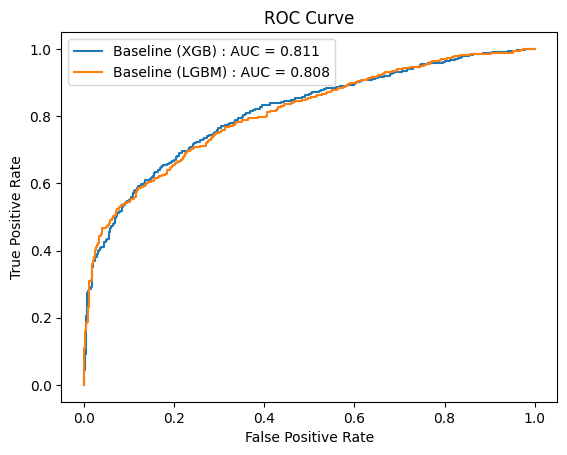

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score

def evaluate_ap_and_auroc(test_labels, test_preds, exp_names):
  assert len(test_labels) == len(test_preds) and len(test_labels) == len(exp_names), \
          "Length of each list should be identical."

  for labels, preds, exp_name in zip(test_labels, test_preds, exp_names):
    fpr, tpr, thresholds = roc_curve(labels, preds)
    auc = roc_auc_score(labels, preds)
    ap = average_precision_score(labels, preds)
    plt.plot(fpr, tpr, label=f'{exp_name} : AUC = {auc:.3f}')
    print(f"[*] {exp_name} : AP = {ap:.3f}, AUROC = {auc:.3f}")

  print("-" * 50)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()
  plt.show()


test_preds = [y_test_proba_xgb[:, 1], y_test_proba_lgbm[:, 1]]
test_labels = [y_test.to_numpy()] * len(test_preds)
exp_names = ['Baseline (XGB)', 'Baseline (LGBM)']

evaluate_ap_and_auroc(test_labels, test_preds, exp_names)

In [ ]:
import numpy as np

EXP_NAME = "baseline_lgbm"
PATH = f"/content/drive/MyDrive/Colab Notebooks/Intro_to_Machine_Learning/weights/{EXP_NAME}_best_preds.npy"
test_preds_probs_best_np = y_test_proba_lgbm[:, 1]

with open(PATH, 'wb') as f:
    np.save(f, test_preds_probs_best_np)

In [ ]:
import numpy as np

EXP_NAME = "baseline_xgboost"
PATH = f"/content/drive/MyDrive/Colab Notebooks/Intro_to_Machine_Learning/weights/{EXP_NAME}_best_preds.npy"
test_preds_probs_best_np = y_test_proba_xgb[:, 1]

with open(PATH, 'wb') as f:
    np.save(f, test_preds_probs_best_np)